In [3]:
from model_bet import Graph_Diff_Reg
import numpy as np
import pickle
import torch
from graph_type import SGNNSample
from scipy.sparse import csr_matrix
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'The following device is used: {device}')

The following device is used: cuda


In [4]:
hidden = 256
n_features= 256
dropout_val = 0.4
learning_rate = 0.00005

model = Graph_Diff_Reg(
    input_dim=n_features,
    hidden_dim=hidden,
    output_dim=1,
    dropout=dropout_val
)

model.to(device)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.00005/10)

training_loss_epochs = []
training_mse_epochs = []

testing_loss_epochs= []
testing_mse_epochs= []

training_score_epochs = []
testing_score_epochs = []

In [5]:
def get_edgelist(A: np.ndarray) -> list[tuple]:
    return [(i, j) for (i, j), val in np.ndenumerate(np.triu(A, k=1)) if val > 0]

def get_weightlist(A: np.ndarray) -> list[tuple]:
    return [val for _, val in np.ndenumerate(np.triu(A, k=1)) if val > 0]

def get_edgelist_tensor(A: np.ndarray) -> torch.Tensor:
    return torch.tensor(get_edgelist(A)).t().contiguous()

def get_weightlist_tensor(A: np.ndarray) -> torch.Tensor:
    return torch.tensor(get_weightlist(A))

def sparse_mx_to_torch_sparse_tensor(sparse_mx) -> torch.FloatTensor:
    """Convert a scipy sparse matrix to a torch sparse tensor."""
    
    sparse_mx = sparse_mx.tocoo().astype(float)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    # FOR UNWEIGHTED, data only contains ones!!!!
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

In [6]:
training_file = 'graphs_500_single_normalized.pkl'

with open(training_file, 'rb') as f:
    pairs = pickle.load(f)

In [7]:
for pair in pairs:
    print(pair.centrality_ratio_normalized)

0.9972840563484964
0.9818509227265211
0.985892564058205
0.9486896958440703
0.9766692327402761
1.0
0.9332600102386234
0.958918497208426
0.9927655004574194
0.9962052614367046
0.9500537839278661
0.9697595450461253
0.9928396607726617
0.9657597990583049
0.9893544837180822
1.0
0.9608199442545775
0.972578977617081
1.0
1.0
0.9948067111475228
1.0
0.9706715648594219
0.9964934950132451
0.9668776781199508
0.9944673408278161
0.9697739685383797
0.9985457338004723
1.0
0.9266290157529912
0.9488199121098757
0.9948037943472298
0.9919705215020881
0.9997463665088264
0.9560332996260973
0.9988455488699624
0.9872519691653384
0.9909114806612579
0.8003735829336222
1.0
0.9776607767621073
0.9188213400217681
0.978748498822281
0.9342182209809565
1.0
0.9182060305577946
0.9664748334421972
0.9117301667276413
0.9955960003306822
0.9784713060996875
0.9999377519063617
1.0
0.952006944323936
1.0
0.9639066317980903
0.9946839087078165
0.9395194645553547
0.9850010272097974
0.983971685573027
0.9987918296906856
0.98282702657038

In [8]:
from tqdm.auto import tqdm, trange
import random

y_trues = []
y_preds = []
loss_history = []
loss_train = 0
mse = 10
n_epoch = 1

avg_mse = 0

print("Training")
print(f"Total Number of epoches: {n_epoch}")
batch_size = 500
t0 = trange(n_epoch, position=0, desc='E', leave=True)
t1 = trange(batch_size, position=1, desc='S', leave=False)
for e in t0:
    t0.set_description(f'E: {avg_mse:.2E}')
    t0.refresh()
    t1.reset(batch_size)
    # print(f"Epoch number: {e+1}/{n_epoch}")
    # print(f"LR: {learning_rate}")
    random.shuffle(pairs)

    for sample in pairs[:batch_size]:
        t1.update()
        # t1.set_description(f'S: {mse:.2E}')
        # t1.refresh()
        edgelist_base     = sample.edgelist_base
        edgelist_base     = edgelist_base.to(device)
        edgelist_modified = sample.edgelist_modified
        edgelist_modified = edgelist_modified.to(device)
        
        

        weightlist_base     = sample.weightlist_base
        weightlist_base     = weightlist_base.to(device)

        weightlist_modified = sample.weightlist_modified
        weightlist_modified = weightlist_modified.to(device)

        feature_matrix = sample.embedding_base
        feature_matrix = feature_matrix.to(device).to_dense()

        batch_vector=np.zeros((feature_matrix.shape[0]),dtype=np.int64)
        batch_vector=torch.tensor(batch_vector)
        batch_vector=batch_vector.to(device)

        y_true = torch.tensor(sample.centrality_ratio_normalized).reshape([1, 1])
        y_true = y_true.to(device).float()

        optimizer.zero_grad()

        y_out = model(
            edgelist_modified,
            weightlist_modified.float(),
            edgelist_base,
            weightlist_base.float(),
            feature_matrix.float(), 
            batch_vector
        )

        mse = loss_fn(y_out, y_true)
            
        mse.backward()

        optimizer.step()

        y_trues.append(float(y_true))
        y_preds.append(float(y_out))

        loss_train += float(mse)
        avg_mse += float(mse)
        loss_history.append(mse)
    avg_mse /= batch_size

loss_train

Training
Total Number of epoches: 1


E:   0%|          | 0/1 [00:00<?, ?it/s]

S:   0%|          | 0/500 [00:00<?, ?it/s]

876188260560.0701

In [9]:
loss_train / n_epoch

876188260560.0701

In [10]:
from sklearn.metrics import r2_score

y_preds

[5570.8330078125,
 516.6289672851562,
 0.10398679971694946,
 -13180.2353515625,
 33875.49609375,
 -15336.5,
 15021.115234375,
 108914.1796875,
 34976.11328125,
 44064.04296875,
 18070.220703125,
 95773.0546875,
 9170.330078125,
 -16668.60546875,
 -54652.5859375,
 8201.919921875,
 -425.3057861328125,
 -20363.140625,
 6290.9501953125,
 -8200.5322265625,
 -15765.271484375,
 -60238.73828125,
 19554.212890625,
 3701.566162109375,
 -8543.69140625,
 -41356.4140625,
 -27815.232421875,
 -3017.560791015625,
 30409.64453125,
 -7847.0693359375,
 0.03696245327591896,
 9253.7978515625,
 -27921.4453125,
 3928.7578125,
 -8788.224609375,
 82780.28125,
 -0.01372222974896431,
 40216.609375,
 43389.9921875,
 -16182.890625,
 82879.4453125,
 -19712.580078125,
 0.07530529797077179,
 73861.0625,
 2589.938232421875,
 42757.46484375,
 36918.83203125,
 -25180.203125,
 -65307.37109375,
 -125449.5,
 -3994.986328125,
 0.05949438363313675,
 -68053.84375,
 -8940.041015625,
 -42063.83203125,
 11195.3203125,
 -35404.36

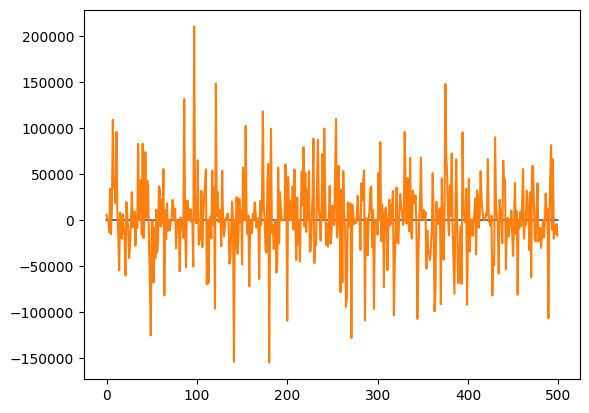

In [11]:
import matplotlib.pyplot as plt
plt.plot(y_trues)
plt.plot(y_preds)

In [27]:
r2_score(y_trues, y_preds)

-166300802821327.66

In [28]:
loss_history = [float(loss) for loss in loss_history]

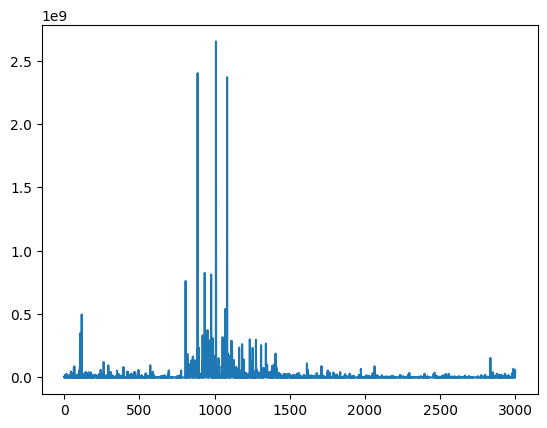

In [31]:
plt.plot(loss_history[2000:5000])

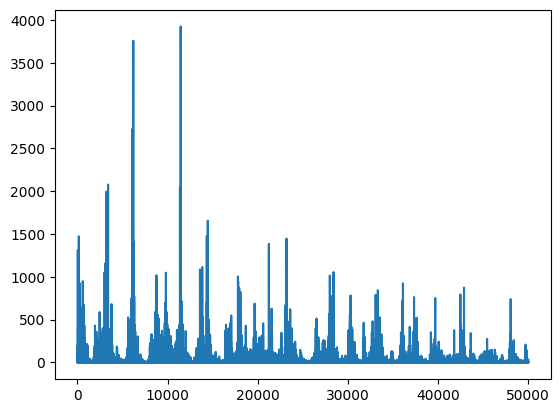

In [52]:
plt.plot(loss_history[150000:])